**Author:** *Golovko Eugene Olegovich* <br>
**Group:** *K-12* <br>
**Variant**: *70* <br>
**Lab instructor:** *Efremov Mykola Serhiiovych*

In [1]:
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

from queue import Queue

In [2]:
FILE_PATH = "./graph.txt"

N = 15
V = 20
K = 5

SIZES = {'node_size': 2000, 'font_size': 25, 'width': 3}
BASE_COLORS = {'font_color': 'black', 'node_color': 'white',  'with_labels': True}
BLACK = {'edgecolors': 'black', 'edge_color': 'black'} | BASE_COLORS


In [3]:
g = nx.read_adjlist(FILE_PATH, nodetype=int, create_using=nx.Graph)

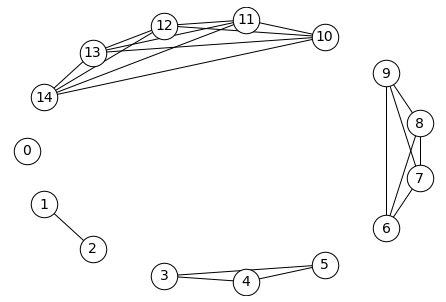

In [4]:
nx.draw_shell(g, **BLACK, node_size=700, font_size=14)

In [5]:
def complete_pos(n, start_index=0, radius=1, x_shift=0, y_shift=0):
    """
    Build circle positions for graph
    
    Parameters
    n : int
        Number of nodes
    
    start_index : int
        Number of first numerical label
    
    radius : float 
        Circle radius
        
    x_shift : float 
        Shift the figure along the x coordinate
    
    y_shift : float
        Shift the figure along the y coordinate
        
    Returns
    dict 
        Dictionary with labels as keys and pairs of x and y coordinates as values
    """
    positions = {}
    first_in_circle = 0
    
    if n == 4:
        positions[start_index] = np.array((x_shift, y_shift)) * radius
        first_in_circle += 1
        
    
    fi = 2 * np.pi / (n - first_in_circle)
    start_rad = np.pi*0.5
        
    return positions | {
        start_index+i : np.array((
            np.cos(-i*fi + start_rad) + x_shift, 
            np.sin(-i*fi + start_rad) + y_shift
        )) * radius
        for i in range(first_in_circle, n)
    }

def completed_components_pos(k, compontnts_distance, radius=1):
    """
    Create circle nodes positions for graph
    
    Parameters
    k : int
        Number of components 
        
    compontnts_distance : float
        Distance between two neighboring components
        
    radius : float
        Radius of circles
        
    Returns
    dict
        Dictionary with labels as keys and pairs of x and y coordinates as values
    """
    res_pos = dict()
    for i in range(k):
        v_in_comp = i+1
        x_shift = (radius*2+compontnts_distance)*i
        
        res_pos |= complete_pos(i+1, start_index=v_in_comp*(v_in_comp-1) // 2, 
                            radius=radius, x_shift=x_shift)
    return res_pos
        

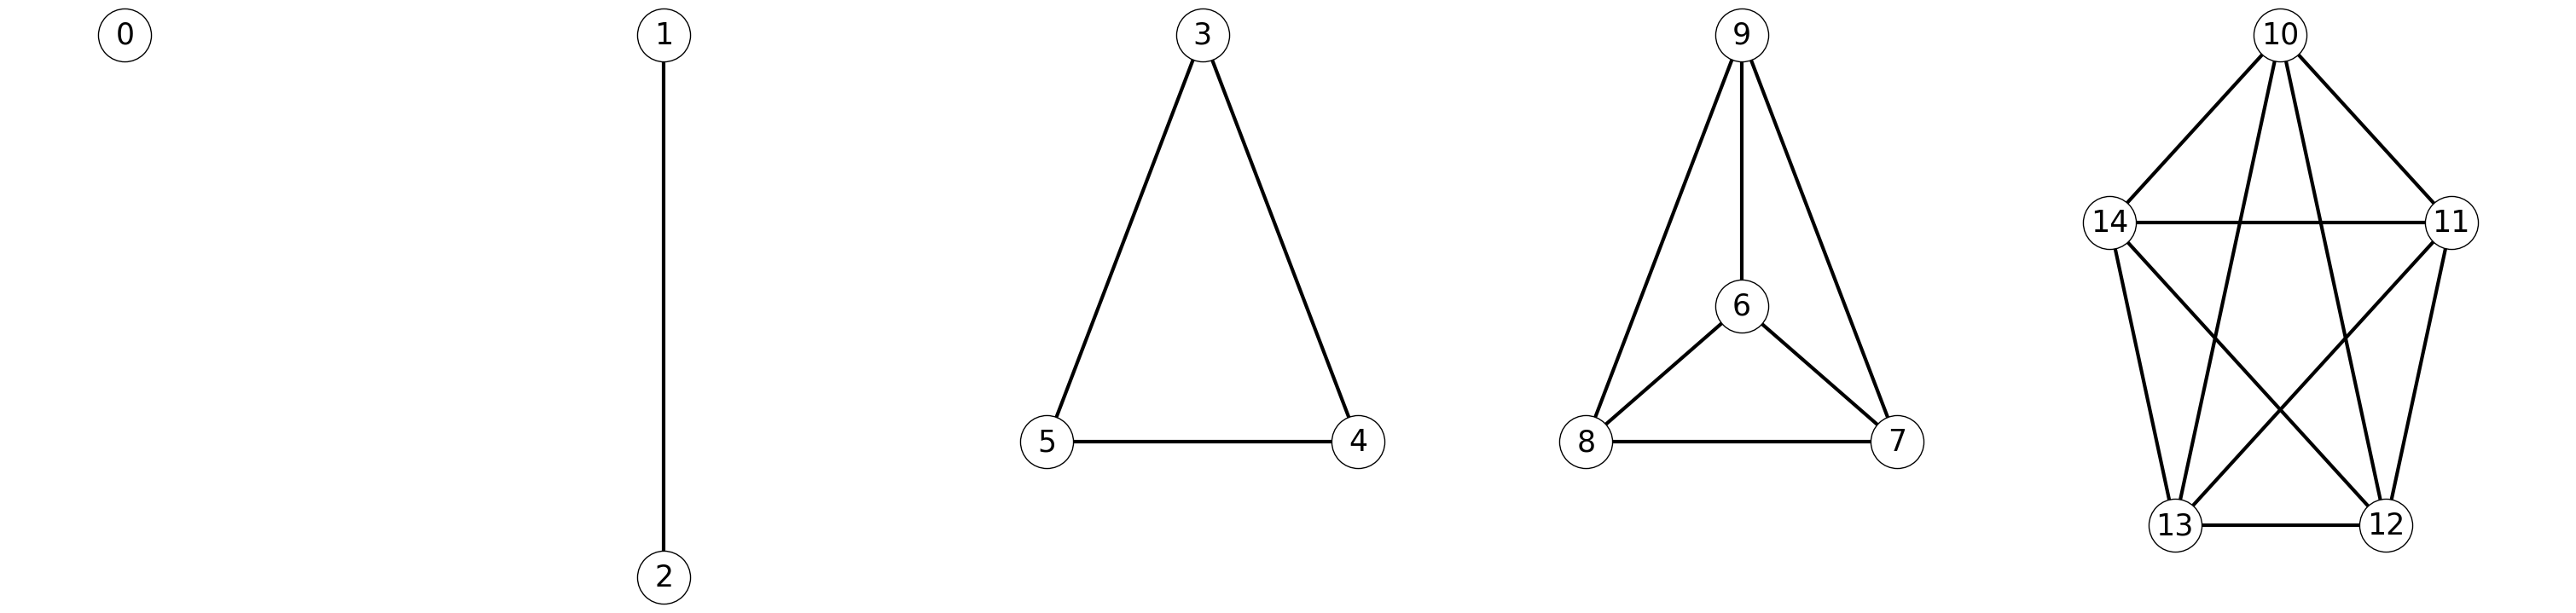

In [6]:
plt.figure(figsize=(30, 7), dpi=100)
nx.draw(g, pos=completed_components_pos(K, 1), **(BLACK|SIZES))

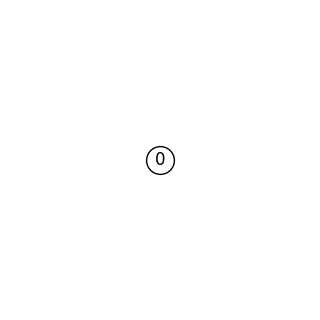

Count of nodes: 1
Count of edges: 0
Node	Degree	Eccentricity
0	0	0




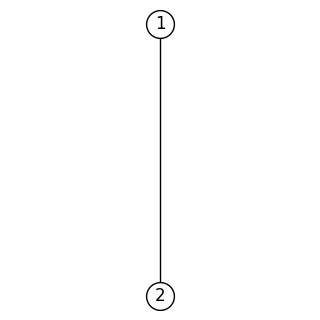

Count of nodes: 2
Count of edges: 1
Node	Degree	Eccentricity
1	1	1
2	1	1




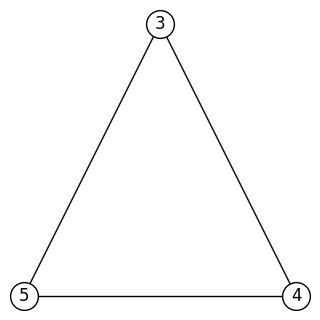

Count of nodes: 3
Count of edges: 3
Node	Degree	Eccentricity
3	2	1
4	2	1
5	2	1




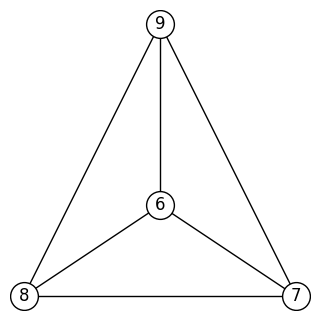

Count of nodes: 4
Count of edges: 6
Node	Degree	Eccentricity
8	3	1
9	3	1
6	3	1
7	3	1




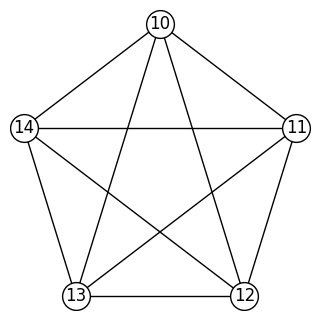

Count of nodes: 5
Count of edges: 10
Node	Degree	Eccentricity
10	4	1
11	4	1
12	4	1
13	4	1
14	4	1




In [7]:
for component_nodes in nx.connected_components(g):
    subgraph = g.subgraph(component_nodes)
    eccentricities = nx.eccentricity(subgraph)
    n_nodes = subgraph.number_of_nodes()
    start_index = n_nodes * (n_nodes-1) // 2
    
    plt.figure(figsize=(3, 3), dpi=100)
    nx.draw(subgraph, pos=complete_pos(n_nodes, start_index=start_index), **BLACK, node_size=400, font_size=12)
    plt.show()
    
    print("Count of nodes:", subgraph.number_of_nodes())
    print("Count of edges:", subgraph.number_of_edges())
    print("Node", "Degree", "Eccentricity", sep="\t")
    
    for node in component_nodes:    
        print(node, end="\t")
        print(g.degree(node), end="\t")
        print(eccentricities[node])
    
    print()
    print()

In [8]:
def _get_key_by_best_result(dictionary, estimator=lambda x: x):
    keys = list(dictionary.keys())
    
    best_key = keys[0]
    best_res = estimator(dictionary[best_key])
    
    for i in range(1, len(keys)):
        key = keys[i]
        
        if estimator(dictionary[key]) > best_res:
            best_key = key
            best_res = estimator(dictionary)
    return best_key

def bfs(graph, start_node):
    """
    Find paths from selected vertex to all other
    
    Parameters
    graph : networkx.Graph
        Connected graph in which the search will be performed.
        
    start_node : int
        Label of starting node
        
    Returns
    dict 
        Dictionary with vertex labels as keys and chain of vertexes as path from start node to other
    """
    
    nodes = dict.fromkeys(graph.nodes, None)
    nodes[start_node] = [start_node]
    
    queue = Queue()
    visited = []
        
    queue.put(start_node)
    visited.append(start_node)
    
    while not queue.empty():
        curr_node = queue.get()
        for neighbor_node in graph.neighbors(curr_node):
            if neighbor_node not in visited:
                nodes[neighbor_node] = nodes[curr_node] + [neighbor_node]
                visited.append(neighbor_node)
                queue.put(neighbor_node)
    return nodes
        

def diameter(graph):
    """
    Find the diameter of connected graph
    
    Parameters 
    graph : networkx.Graph
        Connected graph in which the search will be performed.
        
    Returns:
    list 
        Chain of connected nodes.
    """
    eccentricities = nx.eccentricity(graph)
    start_node = _get_key_by_best_result(eccentricities, lambda x: x)
    paths = bfs(graph, start_node)
    path_key = _get_key_by_best_result(paths, lambda x: len(x))
    return paths[path_key]

def nodes_to_chain_edges(nodes):
    """
    Convert list of connected nodes to list of edges
    
    Parameters
    nodes : list
        List of connected nodes  
    
    Returns
    list 
        List of edges
    """
    edges = []
    for i in range(len(nodes)-1):
        edges.append((nodes[i], nodes[i+1]))
    return edges


In [9]:
diameter_nodes = []
diameter_edges = []

for component_nodes in nx.connected_components(g):
    subgraph = g.subgraph(component_nodes)
    current_diamter_nodes = diameter(subgraph)
    diameter_nodes += current_diamter_nodes
    diameter_edges += nodes_to_chain_edges(current_diamter_nodes)
    
diam_border_colors = ["red" if node in diameter_nodes else "black" for node in g.nodes]
diam_edge_colors = ["red" if (u, v) in diameter_edges or (v, u) in diameter_edges else "black" 
                    for u, v in g.edges]

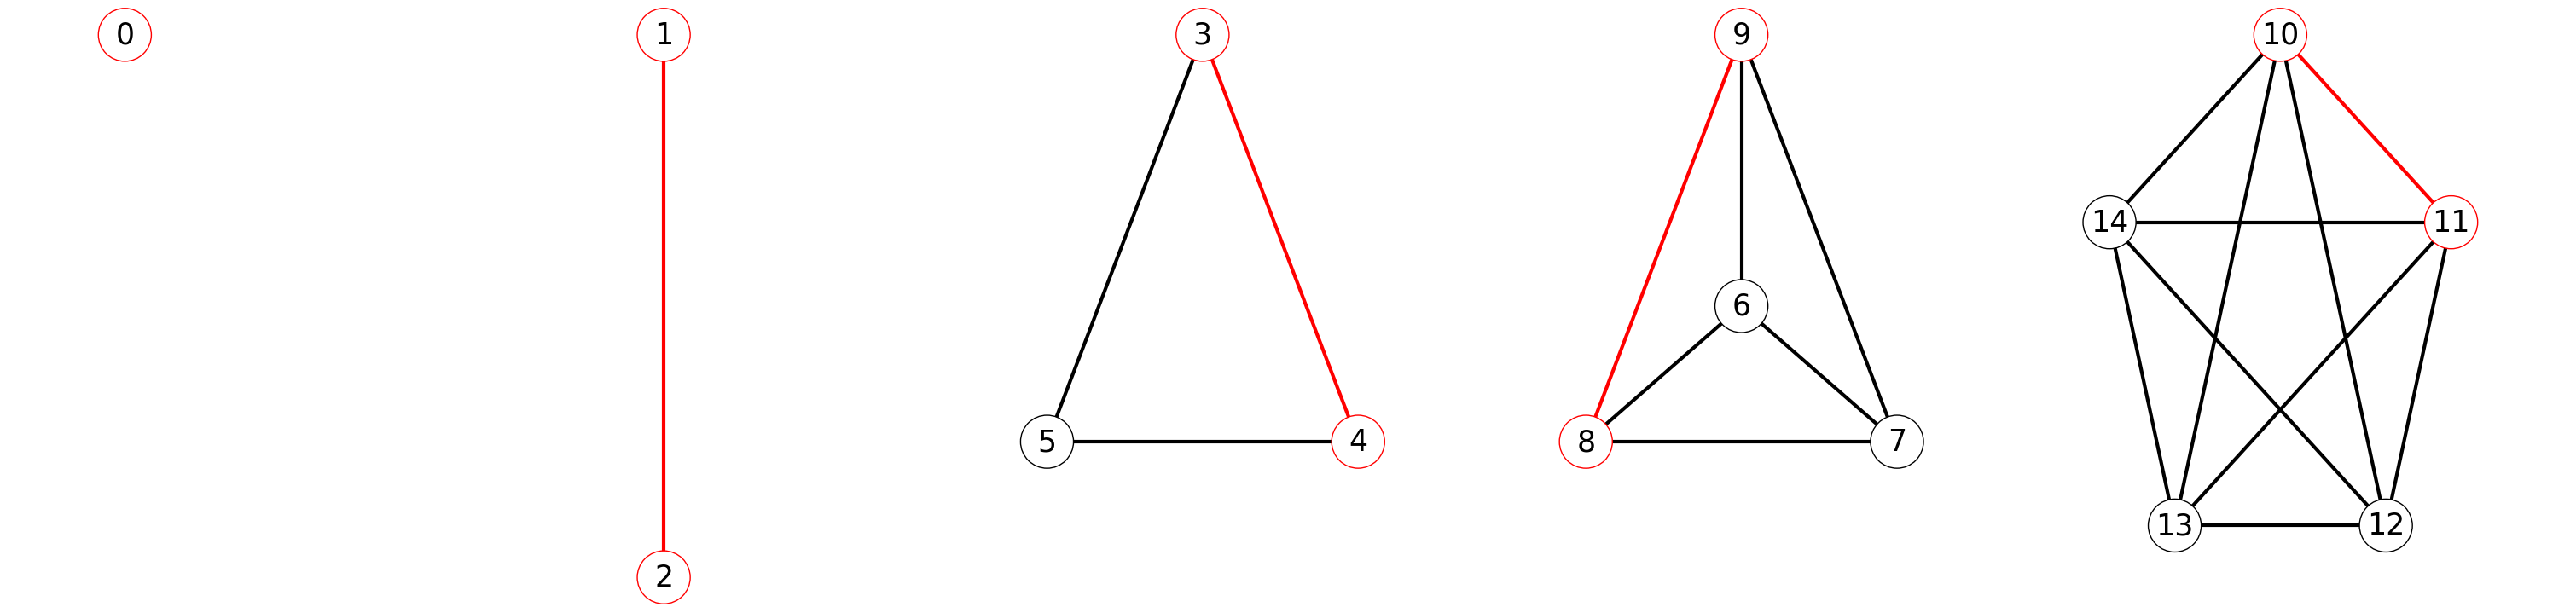

In [10]:
plt.figure(figsize=(30, 7), dpi=100)
nx.draw(g, pos=completed_components_pos(K, 1), **(BASE_COLORS|SIZES), 
        edgecolors=diam_border_colors, edge_color=diam_edge_colors)

In [11]:
tree_edges = set()

for component_nodes in nx.connected_components(g):
    subgraph = g.subgraph(component_nodes)
    start_node = list(subgraph.nodes)[0]
    current_tree = nx.dfs_tree(subgraph, source=start_node)
    current_tree_edges = current_tree.edges()
    tree_edges.update(current_tree_edges)
    
tree_edge_colors = ["red" if (u, v) in tree_edges or (v, u) in tree_edges else "black" 
                    for u, v in g.edges]

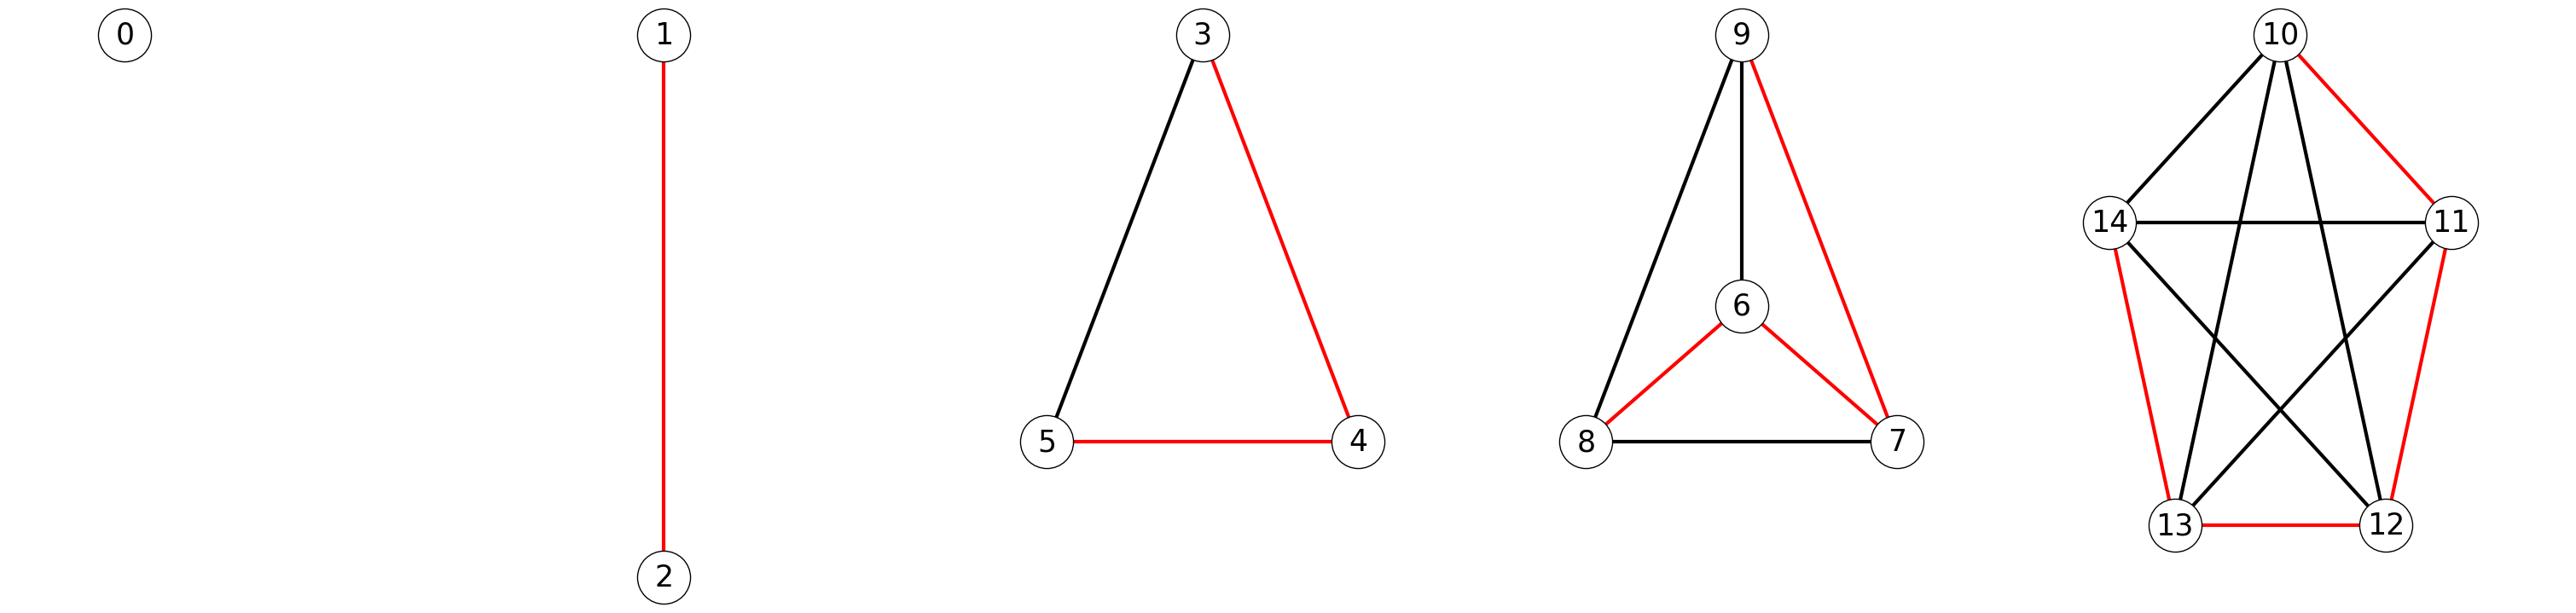

In [12]:
plt.figure(figsize=(30, 7), dpi=100)
nx.draw(g, pos=completed_components_pos(K, 1), **(BASE_COLORS|SIZES),
        edgecolors="black", edge_color=tree_edge_colors)